In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import os
os.chdir("C:\\Users\\Adhvaidh\\Desktop")
df = pd.read_csv("EURUSD_15m_BID_sample.csv")
df.count()

Time      14880
Open      14880
High      14880
Low       14880
Close     14880
Volume    14880
dtype: int64

In [2]:
df.index.min(), df.index.max()

(0, 14879)

In [3]:
df.rename(columns={'Time' : 'timestamp', 'Open' : 'open', 'Close' : 'close', 
                   'High' : 'high', 'Low' : 'low', 'Close' : 'close', 'Volume' : 'volume'}, inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True)
df.set_index('timestamp', inplace=True)
df = df.astype(float)
df.head()

,open,high,low,close,volume
timestamp,,,,,
2015-12-29 00:00:00,1.09746,1.09783,1.09741,1.09772,4.866800e+08
2015-12-29 00:15:00,1.09772,1.09800,1.09770,1.09790,4.459200e+08
2015-12-29 00:30:00,1.09790,1.09805,1.09782,1.09792,1.210700e+09
2015-12-29 00:45:00,1.09792,1.09825,1.09775,1.09808,1.116910e+09
2015-12-29 01:00:00,1.09808,1.09824,1.09791,1.09822,5.038800e+08


In [4]:
df['hour'] = df.index.hour
df['day']  = df.index.weekday
df['week'] = df.index.week
df['momentum']  = df['volume'] * (df['open'] - df['close'])
df['avg_price'] = (df['low'] + df['high'])/2
df['range']     = df['high'] - df['low']
df['ohlc_price'] = (df['low'] + df['high'] + df['open'] + df['close'])/4
df['oc_diff']    = df['open'] - df['close']


In [5]:
from sklearn.decomposition import PCA

dataset = df.copy().values.astype('float32')
pca_features = df.columns.tolist()

pca = PCA(n_components=1)
df['pca'] = pca.fit_transform(dataset)


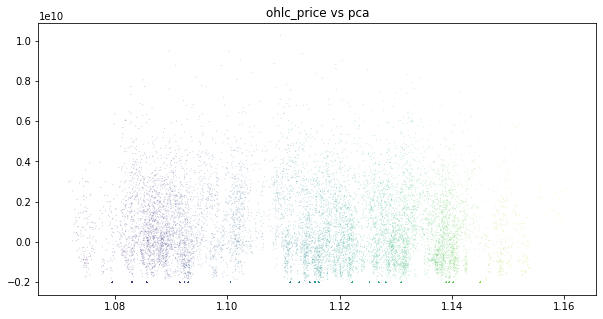

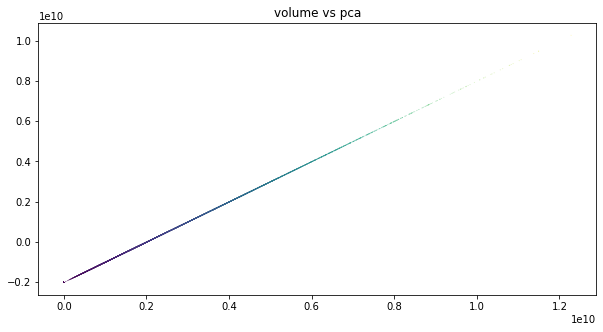

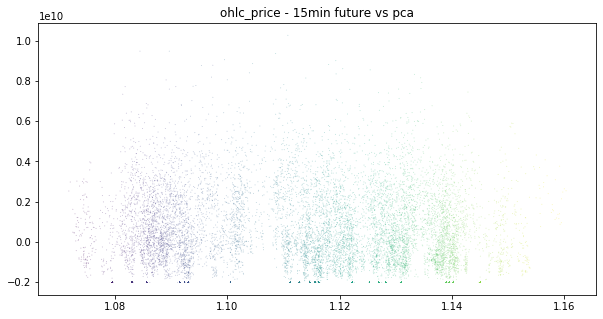

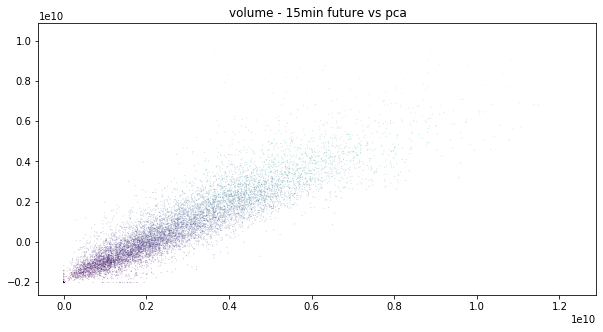

In [6]:
import matplotlib.colors as colors
import matplotlib.cm as cm
import pylab

plt.figure(figsize=(10,5))
norm = colors.Normalize(df['ohlc_price'].values.min(), df['ohlc_price'].values.max())
color = cm.viridis(norm(df['ohlc_price'].values))
plt.scatter(df['ohlc_price'].values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('ohlc_price vs pca')
plt.show()
plt.figure(figsize=(10,5))
norm = colors.Normalize(df['volume'].values.min(), df['volume'].values.max())
color = cm.viridis(norm(df['volume'].values))
plt.scatter(df['volume'].values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('volume vs pca')
plt.show()

plt.figure(figsize=(10,5))
norm = colors.Normalize(df['ohlc_price'].values.min(), df['ohlc_price'].values.max())
color = cm.viridis(norm(df['ohlc_price'].values))
plt.scatter(df['ohlc_price'].shift().values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('ohlc_price - 15min future vs pca')
plt.show()

plt.figure(figsize=(10,5))
norm = colors.Normalize(df['volume'].values.min(), df['volume'].values.max())
color = cm.viridis(norm(df['volume'].values))
plt.scatter(df['volume'].shift().values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('volume - 15min future vs pca')
plt.show()

In [7]:
def create_dataset(dataset, look_back=20):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)


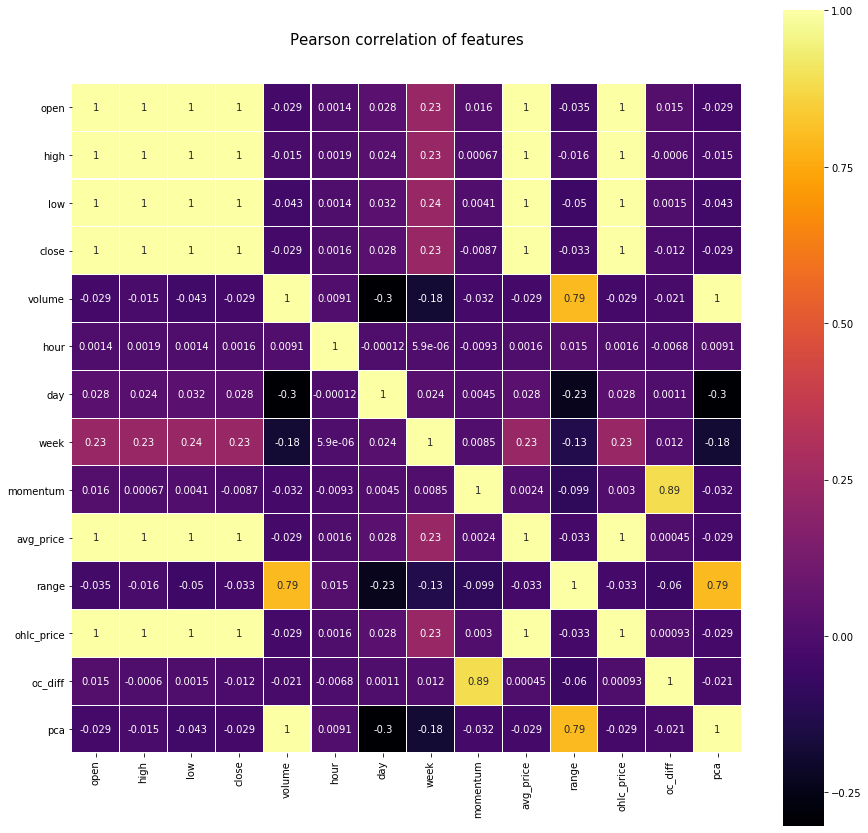

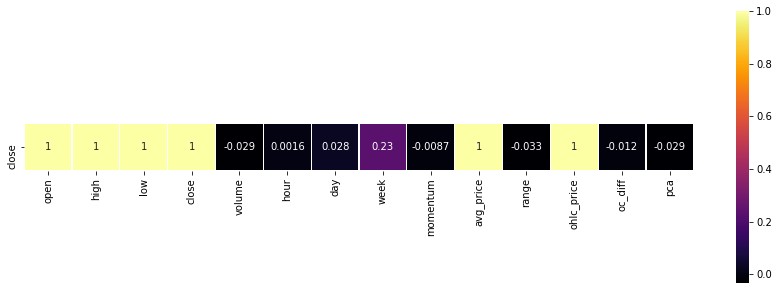

In [8]:
colormap = plt.cm.inferno
plt.figure(figsize=(15,15))
plt.title('Pearson correlation of features', y=1.05, size=15)
sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

plt.figure(figsize=(15,5))
corr = df.corr()
sns.heatmap(corr[corr.index == 'close'], linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True);

In [9]:
from sklearn.ensemble import RandomForestRegressor

# Scale and create datasets
target_index = df.columns.tolist().index('close')
dataset = df.values.astype('float32')

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Set look_back to 20 which is 5 hours (15min*20)
X, y = create_dataset(dataset, look_back=1)
y = y[:,target_index]
X = np.reshape(X, (X.shape[0], X.shape[2]))


In [10]:
forest = RandomForestRegressor(n_estimators = 100)
forest = forest.fit(X, y)

Feature ranking:
0. close 3 (0.810472)
1. ohlc_price 11 (0.070806)
2. avg_price 9 (0.069738)
3. high 1 (0.047906)
4. low 2 (0.000657)
5. open 0 (0.000079)
6. range 10 (0.000060)
7. momentum 8 (0.000059)
8. pca 13 (0.000045)
9. volume 4 (0.000044)
10. oc_diff 12 (0.000043)
11. hour 5 (0.000038)
12. week 7 (0.000028)


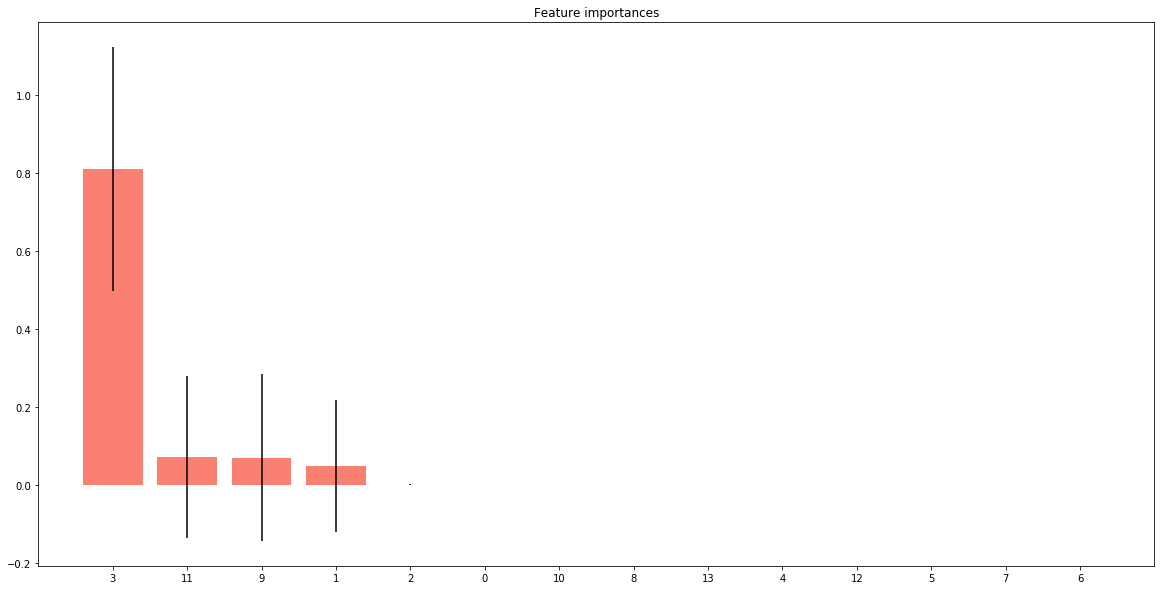

In [11]:
importances = forest.feature_importances_
std = np.std([forest.feature_importances_ for forest in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

column_list = df.columns.tolist()
print("Feature ranking:")
for f in range(X.shape[1]-1):
    print("%d. %s %d (%f)" % (f, column_list[indices[f]], indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="salmon", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [12]:
ax = df.plot(x=df.index, y='close', c='red', figsize=(40,10))
index = [str(item) for item in df.index]
plt.fill_between(x=index, y1='low',y2='high', data=df, alpha=0.4)
plt.show()

p = df[:200].copy()
ax = p.plot(x=p.index, y='close', c='red', figsize=(40,10))
index = [str(item) for item in p.index]
plt.fill_between(x=index, y1='low', y2='high', data=p, alpha=0.4)
plt.title('zoomed, first 200')
plt.show()


KeyError: "None of [DatetimeIndex(['2015-12-29 00:00:00', '2015-12-29 00:15:00',\n               '2015-12-29 00:30:00', '2015-12-29 00:45:00',\n               '2015-12-29 01:00:00', '2015-12-29 01:15:00',\n               '2015-12-29 01:30:00', '2015-12-29 01:45:00',\n               '2015-12-29 02:00:00', '2015-12-29 02:15:00',\n               ...\n               '2016-05-31 21:30:00', '2016-05-31 21:45:00',\n               '2016-05-31 22:00:00', '2016-05-31 22:15:00',\n               '2016-05-31 22:30:00', '2016-05-31 22:45:00',\n               '2016-05-31 23:00:00', '2016-05-31 23:15:00',\n               '2016-05-31 23:30:00', '2016-05-31 23:45:00'],\n              dtype='datetime64[ns]', name='timestamp', length=14880, freq=None)] are in the [columns]"

In [13]:
target_index = df.columns.tolist().index('close')
high_index = df.columns.tolist().index('high')
low_index = df.columns.tolist().index('low')
dataset = df.values.astype('float32')

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Create y_scaler to inverse it later
y_scaler = MinMaxScaler(feature_range=(0, 1))
t_y = df['close'].values.astype('float32')
t_y = np.reshape(t_y, (-1, 1))
y_scaler = y_scaler.fit(t_y)
    
# Set look_back to 20 which is 5 hours (15min*20)
X, y = create_dataset(dataset, look_back=20)
y = y[:,target_index]
# Set training data size
# We have a large enough dataset. So divid into 98% training / 1%  development / 1% test sets
train_size = int(len(X) * 0.99)
trainX = X[:train_size]
trainY = y[:train_size]
testX = X[train_size:]
testY = y[train_size:]


In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, Dense

# create a small LSTM network
model = Sequential()
model.add(LSTM(20, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(LSTM(20, return_sequences=True))
model.add(LSTM(10, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(4, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 20)            2800      
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 20)            3280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 10)            1240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 10)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 4)                 240       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_______________________________________

In [15]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

# Fit
callbacks_list = [checkpoint]
history = model.fit(trainX, trainY, epochs=200, batch_size=500, verbose=0, callbacks=callbacks_list, validation_split=0.1)

C:\Users\Adhvaidh\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_mean_squared_error available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


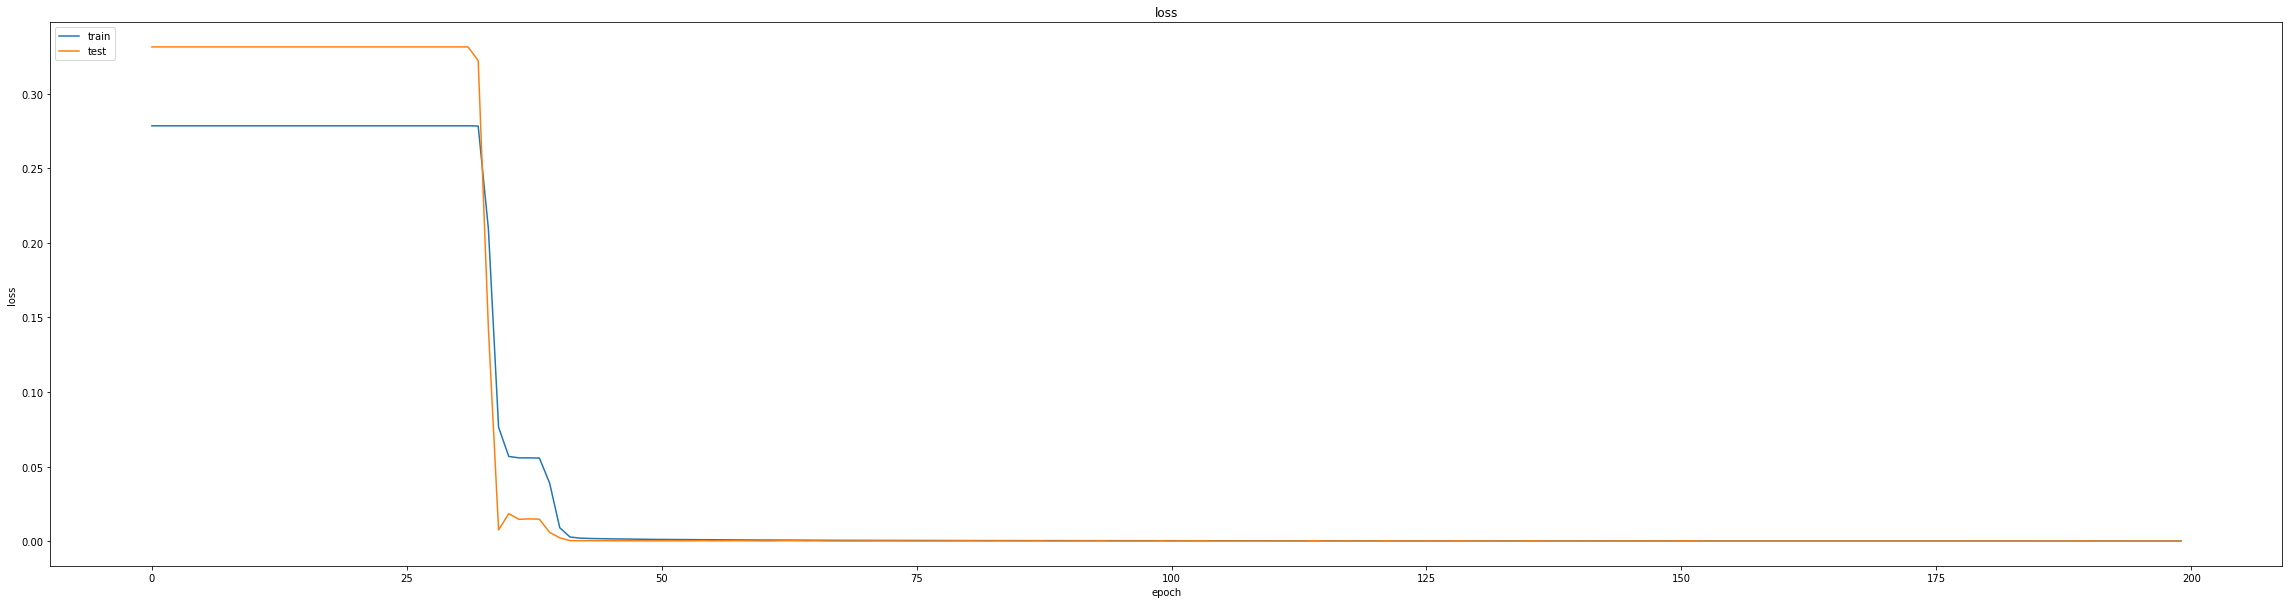

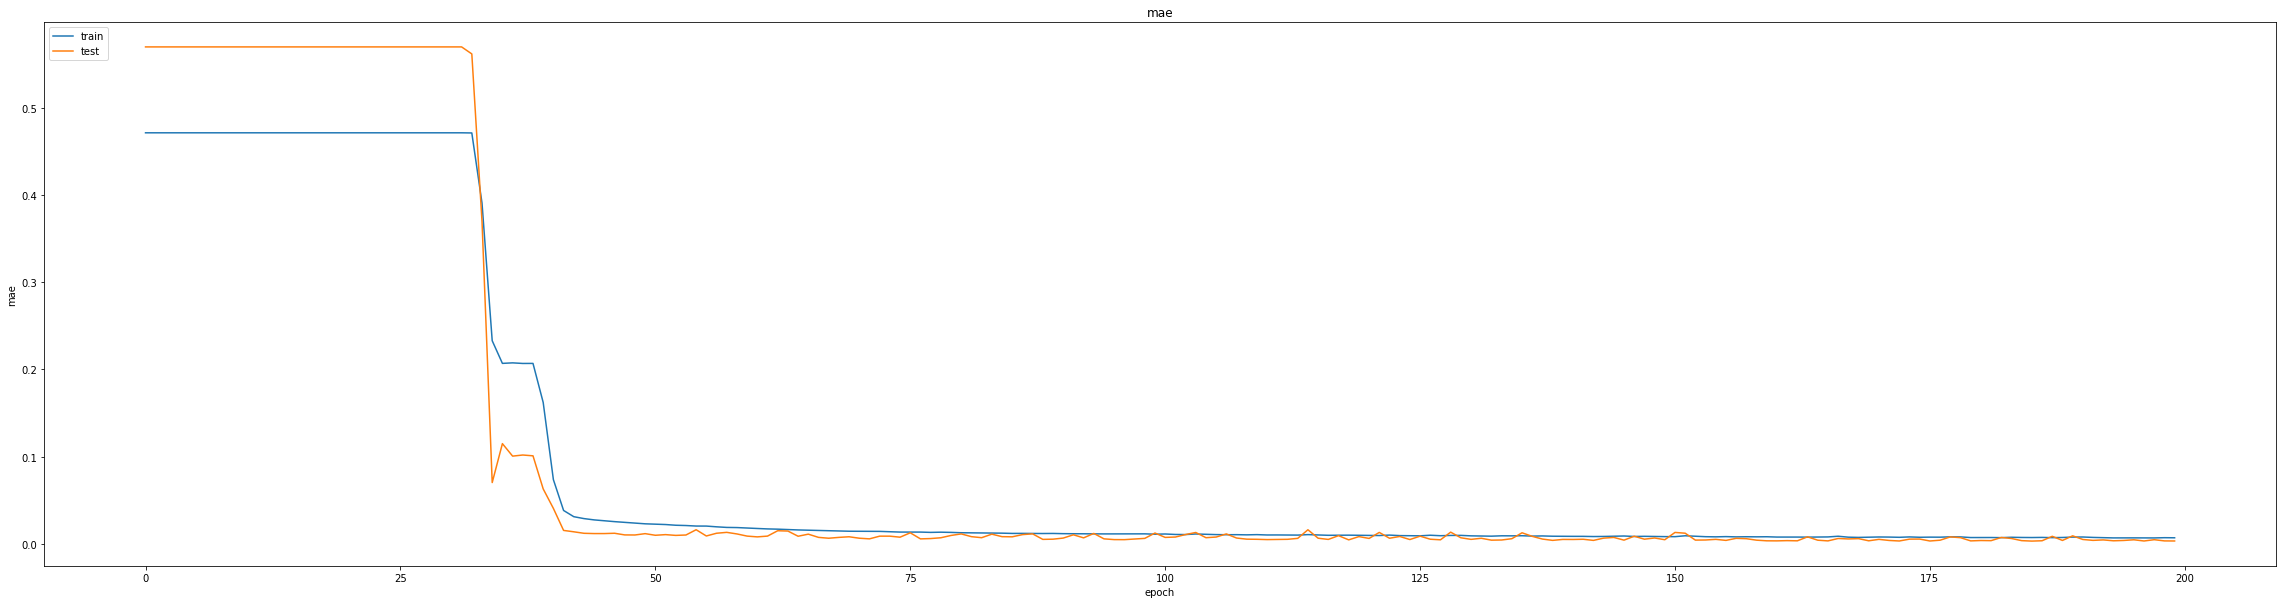

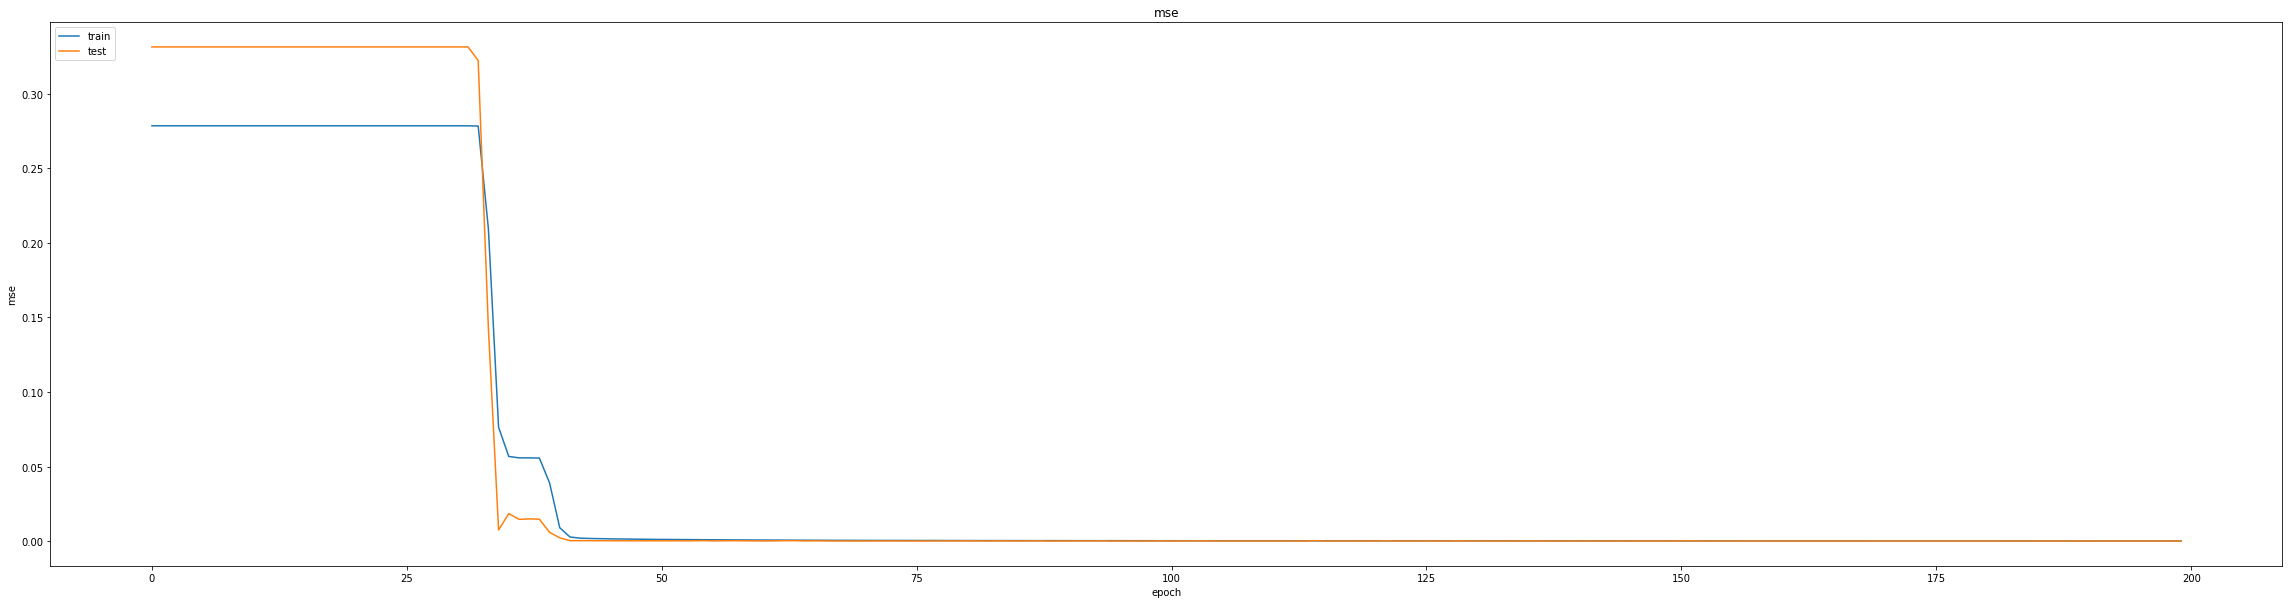

In [16]:
epoch = len(history.history['loss'])
for k in list(history.history.keys()):
    if 'val' not in k:
        plt.figure(figsize=(40,10))
        plt.plot(history.history[k])
        plt.plot(history.history['val_' + k])
        plt.title(k)
        plt.ylabel(k)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()


In [19]:
model.load_weights("model.weights.best.hdf5")

# Train again with decaying learning rate
from keras.callbacks import LearningRateScheduler
import keras.backend as K

def scheduler(epoch):
    if epoch%2==0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr*.9)
        print("lr changed to {}".format(lr*.9))
    return K.get_value(model.optimizer.lr)
lr_decay = LearningRateScheduler(scheduler)

callbacks_list = [checkpoint, lr_decay]
history = model.fit(trainX, trainY, epochs=int(epoch/3), batch_size=500, verbose=0, callbacks=callbacks_list, validation_split=0.1)

OSError: Unable to open file (unable to open file: name = 'model.weights.best.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)